World of Tanks: Free to Play, Pay to Enjoy

Jeffrey Lyngdoh

In [85]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn import linear_model
import numpy as np
import statsmodels.api as sm
from scipy import stats



Data curation

We will gather our data by scraping a webpage from tomato.gg, the premier source for World of Tanks statistics which collects aggregate data from players and vehicles within the last 60 days. There are two web pages we will be looking at. The first is the tank stat page which contains data about battles, winrate, damage and other statistics relevant to the actual gameplay. The second is the tank economy page which contains data related to credit earning through vehicles including repair cost, average earning per game, ammo cost, etc.


Battle Stats: https://www.tomato.gg/tank-stats/NA


Economy Stats: https://www.tomato.gg/economics/all

IMPORTANT

tomato.gg is updated often and frequently, sometimes the structure of the webpage changes or variable names do, this can be unreliable as my project is based on collecting specific bits of information or information can be moved. As a result I have opted to escape the webpage one and save the data in csv files in the folder rawDataOutput. These files will be used for the actual data analysis in my project, they are up to date as of April 2023 which will suffice for the purpose of my project. Below I have provided the code I used to initially scrape these webpages, they will write their results to the output file if you are curious however they will not be used in my work. It is possible the code below doesn't work for the reasons listed before.

In [86]:
url = "https://www.tomato.gg/tank-stats/NA"

response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

script = soup.find("script", {"id": "__NEXT_DATA__"})

if script:
    contents = script.contents[0]
    data = json.loads(contents)
    initial_data = data["props"]["pageProps"]["data"]
    
    fieldnames = set()
    for obj in initial_data:
        fieldnames.update(obj.keys())

    filename = "output.csv"

    with open(filename, mode="w", newline="", encoding="utf-8") as file:  
        writer = csv.DictWriter(file, fieldnames=list(fieldnames))
        writer.writeheader()
        writer.writerows(initial_data)   
else:
    print("Error data not found")


In [87]:
url = "https://www.tomato.gg/economics/all"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

script = soup.find("script", {"id": "__NEXT_DATA__"})
if script:
    contents = script.contents[0]
    data = json.loads(contents)
    initial_data = data["props"]["pageProps"]["data"]['data']

    fieldnames = set()
    for obj in initial_data:
        fieldnames.update(obj.keys())
        
    filename = "output.csv"

    with open(filename, mode="w", newline="", encoding="utf-8") as file:  # Specify UTF-8 encoding
        writer = csv.DictWriter(file, fieldnames=list(fieldnames))
        writer.writeheader()
        writer.writerows(initial_data)  
    
else:
    print("Error data not found")

Parsing and Management

We can convert our files into dataframes. One for tank economies and another for general battle stats. We can combine them based on tank ids. The resulting data frame has a lot of attributes which we don’t need so we can simply create a new dataframe and insert all relevant columns. This data frame has information of more than 500 tanks.


In [88]:
data = pd.DataFrame()
generalDf = pd.read_csv('rawDataOutput/generalData.csv', encoding='utf')
economicDF = pd.read_csv('rawDataOutput/econData.csv', encoding='utf')

combinded = pd.merge(generalDf, economicDF, how='inner', on='tank_id')


data['Id'] = combinded['tank_id']
data['Name'] = combinded['name_x']
data['isPrem'] = combinded['isPrem_x']
data['tier'] = combinded['tier_x']
data['class'] = combinded['class_x']

data['battles'] = combinded['battles_x']
data['winrate'] = combinded['winrate']
data['survival'] = combinded['survival']
data['damage'] = combinded['damage']
data['shotCost'] = combinded['cost_per_shot']
data['repairCost'] = combinded['avg_repair_cost']
data['avg_ammo_cost'] = combinded['avg_ammo_cost']
data['avg_profit'] = combinded['avg_profit']

data

,Id,Name,isPrem,tier,class,battles,winrate,survival,damage,shotCost,repairCost,avg_ammo_cost,avg_profit
0,60225,Bourrasque,True,8,MT,110271,53.36,27.44,1391,2966,6483,25621,39962
1,50193,Skorpion G,True,8,TD,82120,48.96,30.85,1264,2196,5967,16537,42051
2,61505,ELC EVEN 90,True,8,LT,80964,50.58,23.45,593,1875,4725,10728,37193
3,45057,SU-130PM,True,8,TD,77995,49.72,34.90,1386,2088,5610,15900,44788
4,60481,Char Futur 4,True,9,MT,72969,50.34,28.56,1539,1841,15545,16574,7018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,4417,G1 R,False,5,MT,202,49.34,26.24,482,2524,2101,29383,-10336
552,13393,Archer,False,5,TD,186,50.98,36.02,628,1013,2116,15252,-643
553,63761,Pz. 58,True,8,MT,148,46.85,25.00,868,2621,6897,25891,25114
554,52257,M4A2E4,True,5,MT,89,53.07,19.10,488,2208,1591,54534,-12086


Now that data is centralized let's start by observing some simple trends. Two features that are relatively initiative is winrate and profit. Having a higher winrate and gaining more profit in the game is the ultimate goal of each battle. We can observe a clear difference between standard free tanks and premium ones.
 

Let's start with winrate we can divide the data into two groups, premium and non premium dataframes. We can then place both on scatter plots. After that we can apply a line of best fit for both sets using a linear regression model.

Note:
The number of battles a tank plays can skew the result. For example if a tank is only placed once in which it wins it will be listed as having a 100% winrate. Tanks with fewer battles have a greater chance of producing outliers.As such we have limited this plot to tanks with only 1000 battles or more which paints a more accurate picture of performance.


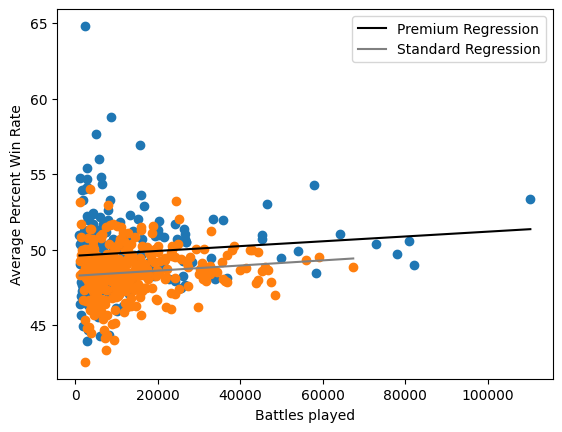

In [89]:
premiumGeneral = data[data['isPrem'] == True ]
stdGeneral = data[data['isPrem'] == False]


premiumGeneral = premiumGeneral[premiumGeneral['battles'] > 1000]
stdGeneral = stdGeneral[stdGeneral['battles'] > 1000]

reg = linear_model.LinearRegression()

x = np.array(premiumGeneral['battles']).reshape(-1,1)
y = premiumGeneral['winrate']

reg.fit(x,y)

predictions = reg.predict(x)
plt.scatter(x,y)
plt.plot(x, predictions, color='black', label='Premium Regression')

x = np.array(stdGeneral['battles']).reshape(-1,1)
y = stdGeneral['winrate']

reg.fit(x,y)

predictions = reg.predict(x)
plt.scatter(x,y)
plt.plot(x, predictions, color='gray', label='Standard Regression')

plt.xlabel('Battles played')
plt.ylabel('Average Percent Win Rate')
plt.legend()

plt.show()

The plot certainly seems to suggest a higher winrate for premium tanks compared to standard ones. However correlation is not always causation. Inorder to confidently make this conclusion we can perform hypothesis testing.


We can define our null and alternative hypothesis


Null hypothesis: The winrate of premium tanks is the same as the winrate of non-premium tanks.


Alternative hypothesis: The winrate of premium tanks is higher than the winrate of non-premium tanks.


We will set our significance level to 0.05 to reject the null hypothesis.
We can then use scipy to calculate p value.


In [90]:
gold_winrates = premiumGeneral['winrate']
standard_winrates = stdGeneral['winrate']

t_stat, p_val = stats.ttest_ind(gold_winrates, standard_winrates, equal_var=False)

print("t-statistic: " + str(t_stat))
print("p-value: " + str(p_val))

if(p_val < 0.05):
    print('Reject Null Hypothesis')
else:
    print('Null Hypotheis remains true')

t-statistic: 6.357030379930079
p-value: 7.149980735576287e-10
Reject Null Hypothesis


The result p value is significantly smaller than the sigingicants level therefore we can reject the null hypothesis and claim The winrate of premium tanks is higher than the winrate of non-premium tanks.


We can now apply a similar process to profits. We again split the data into two and plot average profit per battle. We can apply linear regression lines and observe the trend.


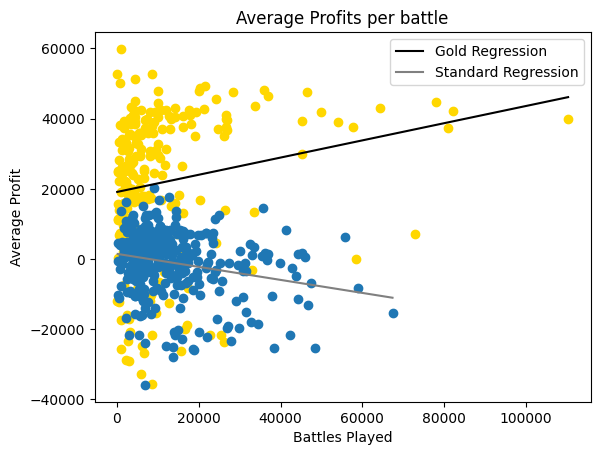

In [91]:
premiumEcon = data[data['isPrem'] == True]
stdEcon = data[data['isPrem'] == False]

reg = linear_model.LinearRegression()

x = np.array(premiumEcon['battles']).reshape(-1,1)
y = premiumEcon['avg_profit']

reg.fit(x,y)

predictions = reg.predict(x)
plt.scatter(x,y,color = 'gold')
plt.plot(x, predictions, color='black', label='Gold Regression')

x = np.array(stdEcon['battles']).reshape(-1,1)
y = stdEcon['avg_profit']

reg.fit(x,y)
predictions = reg.predict(x)
plt.scatter(x,y)
plt.plot(x, predictions, color='gray', label='Standard Regression')

plt.ylabel('Average Profit')
plt.xlabel('Battles Played')
plt.title('Average Profits per battle')
plt.legend()
plt.show()

We can clearly see a positive trend for premium tanks and a negative one for standard tanks. This may not be necessary but we can again apply hypothesis testing to confirm a correlation.


Null Hypothesis: Premium tanks earn an equal amount of credits


Alternative Hypothesis: Premium tanks earn more than standard ones.


In [92]:
gold_profits = premiumEcon['avg_profit']
standard_profit = stdEcon['avg_profit']

t_stat, p_val = stats.ttest_ind(gold_winrates, standard_winrates, equal_var=False)

print("t-statistic: " + str(t_stat))
print("p-value: " + str(p_val))

if(p_val < 0.05):
    print('Reject Null Hypothesis')
else:
    print('Null Hypotheis remains true')

t-statistic: 6.357030379930079
p-value: 7.149980735576287e-10
Reject Null Hypothesis


The p value is smaller than our significance level and therefore we can reject the null hypothesis and claim Premium tanks earn more than standard ones.


It may seem strange how standard tanks lose money after each game. Especially considering players have to use credits to buy ammo and repair their tanks. As it turns out this data is a bit misleading. Higher tier tanks consume more credits to play than lower tier ones.For example if we look at profits earned from tanks tier 5 and lower we get the following.


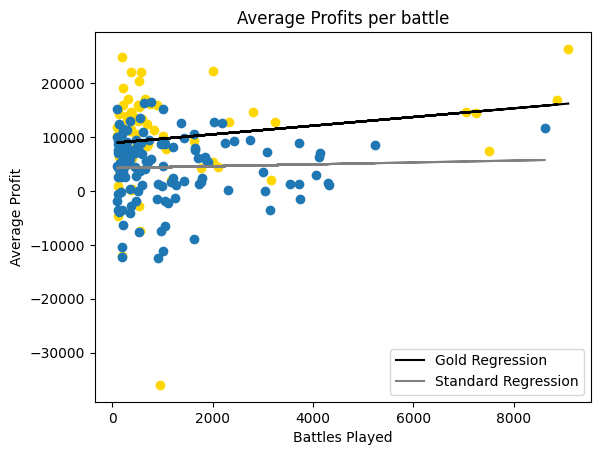

In [93]:
premiumEcon = economicDF[economicDF['isPrem'] == True]
stdEcon = economicDF[economicDF['isPrem'] == False]

stdEcon = stdEcon[stdEcon['tier'] < 6]
premiumEcon = premiumEcon[premiumEcon['tier'] < 6]

reg = linear_model.LinearRegression()

x = np.array(premiumEcon['battles']).reshape(-1,1)
y = premiumEcon['avg_profit']

reg.fit(x,y)

predictions = reg.predict(x)
plt.scatter(x,y,color = 'gold')
plt.plot(x, predictions, color='black', label='Gold Regression')

x = np.array(stdEcon['battles']).reshape(-1,1)
y = stdEcon['avg_profit']

reg.fit(x,y)
predictions = reg.predict(x)
plt.scatter(x,y)
plt.plot(x, predictions, color='gray', label='Standard Regression')

plt.ylabel('Average Profit')
plt.xlabel('Battles Played')
plt.title('Average Profits per battle')
plt.legend()
plt.show()

As we can see lower tier standard tanks are able to make marginal profit. This intentional World of Tanks works to encourage its players to use lower tier vehicles. This design may be benign, perhaps encouraging players to unlock different tank paths. To be more nefarious such as limiting the number of free players in the higher tiers in order to keep them more exclusive to paying customers. The latter reason may be more realistic as premium tanks are not hampered by the same limitation as standard ones. As we saw prior premium tanks always make profit regardless of tier.

Seeing the large difference in profit between premium and non premiums it may be fair to assume that being premium is the largest factor in a tanks profit. Is this actually the case though? Doing well in a battle may earn you more credits. Surviving the battle without getting destroyed means you don’t have to pay a repair cost. The cost of ammo or the type of vehicle may also play a role. We can determine this using statistical models. 


Looking at our data we can see several columns and work to determine which ones most influence average profit. We can naturally exclude Id and name which have no bearing. We can represent if a tank is a premium with binary 1 and 0. It is possible the type of vehicle also affects profit so we can represent them as integers.


In [94]:
data['binaryPrem'] = data['isPrem'].apply(lambda x : 1 if x else 0)
types = {'SPG' : 0, 'LT' : 1, 'MT' : 2, 'HT' : 3, 'TD' : 4}
data['numClass'] = data['class'].apply(lambda x : types[x])
data

,Id,Name,isPrem,tier,class,battles,winrate,survival,damage,shotCost,repairCost,avg_ammo_cost,avg_profit,binaryPrem,numClass
0,60225,Bourrasque,True,8,MT,110271,53.36,27.44,1391,2966,6483,25621,39962,1,2
1,50193,Skorpion G,True,8,TD,82120,48.96,30.85,1264,2196,5967,16537,42051,1,4
2,61505,ELC EVEN 90,True,8,LT,80964,50.58,23.45,593,1875,4725,10728,37193,1,1
3,45057,SU-130PM,True,8,TD,77995,49.72,34.90,1386,2088,5610,15900,44788,1,4
4,60481,Char Futur 4,True,9,MT,72969,50.34,28.56,1539,1841,15545,16574,7018,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,4417,G1 R,False,5,MT,202,49.34,26.24,482,2524,2101,29383,-10336,0,2
552,13393,Archer,False,5,TD,186,50.98,36.02,628,1013,2116,15252,-643,0,4
553,63761,Pz. 58,True,8,MT,148,46.85,25.00,868,2621,6897,25891,25114,1,2
554,52257,M4A2E4,True,5,MT,89,53.07,19.10,488,2208,1591,54534,-12086,1,2


Using our data we can sit revenant columns into a data stat learning model. From there we can determine p values from each respective attribute. Using the same significant value from before we can single out which attributes are likely to contribute to average profits.


In [95]:
X = data[['binaryPrem', 'tier', 'numClass', 'winrate', 'survival', 'damage', 'shotCost', 'repairCost', 'avg_ammo_cost']]
y = data['avg_profit']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

pVals = model.pvalues

pVals.sort_values(ascending=False)
pVals = pVals[pVals < 0.05]
pVals

binaryPrem       9.662444e-54
tier             4.002829e-24
survival         3.062961e-05
damage           2.382668e-06
repairCost       4.065880e-53
avg_ammo_cost    9.998197e-15
dtype: float64

Knowing what factors affect profit one might ask is it possible to predict profits given relevant information. This is indeed possible that we can construct a machine learning function that predicts profit.


We can make a machine learning function that predicts average profit after a battle given this data we will use gradiant decent
 

In [96]:
trainingData = pd.DataFrame()

trainingData['binaryPrem'] = data['binaryPrem']
trainingData['tier'] = data['tier']
trainingData['survival'] = data['survival']
trainingData['damage'] = data['damage']
trainingData['repairCost'] = data['repairCost']
trainingData['avg_ammo_cost'] = data['avg_ammo_cost']
trainingData['avg_profit'] = data['avg_profit']
trainingData



,binaryPrem,tier,survival,damage,repairCost,avg_ammo_cost,avg_profit
0,1,8,27.44,1391,6483,25621,39962
1,1,8,30.85,1264,5967,16537,42051
2,1,8,23.45,593,4725,10728,37193
3,1,8,34.90,1386,5610,15900,44788
4,1,9,28.56,1539,15545,16574,7018
...,...,...,...,...,...,...,...
551,0,5,26.24,482,2101,29383,-10336
552,0,5,36.02,628,2116,15252,-643
553,1,8,25.00,868,6897,25891,25114
554,1,5,19.10,488,1591,54534,-12086


In [117]:
def gradientDescent(X, y, theta, alpha, iterations):
    m = len(y)
    for i in range(iterations):
        h = np.dot(X, theta)
        theta -= alpha * (1/m) * np.dot(X.T, (h-y))
    return theta

In [118]:
y = trainingData["avg_profit"]
X = trainingData.drop("avg_profit", axis=1)

In [119]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X = np.hstack((np.ones((X.shape[0], 1)), X))

alpha = 0.05
num_iterations = 10000
theta = np.zeros(X.shape[1])

In [120]:
theta = gradientDescent(X, y, theta, alpha, num_iterations)
print("Learned Parameters (Theta):", theta)

Learned Parameters (Theta): [  8468.31834532   8374.44159171  11492.51730421  -2144.38930847
   6634.61653471 -20665.12756909  -6483.80719232]


In [121]:
def predictProfit(isPrem, tier, survival, damage, repairCost, ammoCost):
    profit = 0
    
    premNorm = (isPrem - np.mean(trainingData["binaryPrem"])) / np.std(trainingData["binaryPrem"])
    tierNorm = (tier - np.mean(trainingData["tier"])) / np.std(trainingData["tier"])
    survivalNorm = (survival - np.mean(trainingData['survival'])) / np.std(trainingData['survival'])
    damageNorm = (damage - np.mean(trainingData['damage'])) / np.std(trainingData['damage'])
    repairNorm = (repairCost - np.mean(trainingData['repairCost'])) / np.std(trainingData['repairCost'])
    ammoNorm = (ammoCost - np.mean(trainingData['avg_ammo_cost'])) / np.std(trainingData['avg_ammo_cost'])

    features = np.array([1, premNorm, tierNorm, survivalNorm, damageNorm, repairNorm, ammoNorm])
    profit = np.dot(features, theta)
    
    return profit
    

In [122]:
prem = {True : 1, False : 0}

prem = prem[False]
tier = 7
survival = 25.86
damage = 894
repairCost = 8700
ammoCost = 20000

profit = predictProfit(prem,tier,survival,damage,repairCost,ammoCost)
print("Predicted profit:", profit)


Predicted profit: -2492.270070122117


In [123]:
predictions = trainingData.apply(
    lambda row: 
        predictProfit(row['binaryPrem'], row['tier'], row['survival'], row['damage'], row['repairCost'], row['avg_ammo_cost']), axis=1)

errors = np.abs(predictions - trainingData['avg_profit'])

avg_error = np.mean(errors)
print("Average error:", avg_error)

Average error: 6799.676382474539


https://www.tomato.gg/economics/all


In [124]:
def estimateTankProfit(name):
    tank = data[data['Name'] == name]
    
    if not tank.empty:
        isPrem = tank['isPrem'].values[0]
        tier = tank['tier'].values[0]
        survival = tank['survival'].values[0]
        damage = tank['damage'].values[0]
        repair = tank['repairCost'].values[0]
        avg_ammo_cost = tank['avg_ammo_cost'].values[0]

        profit = predictProfit(isPrem, tier, survival, damage, repair, avg_ammo_cost)
        error = abs(profit - tank['avg_profit']).values[0]
        print("Estimated Profit: " + str(profit))
        print("Off by: " + str(error))

    else:
        print('Tank not Found')



estimateTankProfit('AMX M4 45')

Estimated Profit: -2451.5794335036317
Off by: 2390.5794335036317


In [125]:
import numpy as np

def gradient_Descent(X, y, theta, alpha, iterations):
    m = len(y)
    loss_history = []
    for i in range(iterations):
        h = np.dot(X, theta)
        theta -= alpha * (1/m) * np.dot(X.T, (h-y))
        loss = np.sum(np.power(h-y, 2))/(2*m)
        loss_history.append(loss)
    return theta, np.array(loss_history)


Learned Parameters (Theta): [  8468.31834532   8374.44159171  11492.51730421  -2144.38930847
   6634.61653471 -20665.12756909  -6483.80719232]
[40481560.12257043 40481560.12257043 40481560.12257043 ...
 40481560.12257043 40481560.12257043 40481560.12257043]


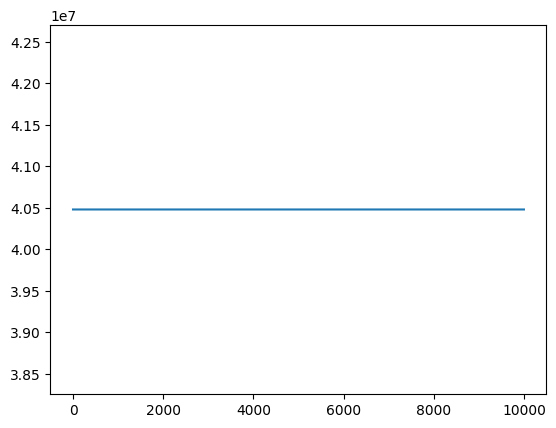

In [129]:
theta, f = gradient_Descent(X, y, theta, alpha, num_iterations)
print("Learned Parameters (Theta):", theta)
print(f)
plt.plot(range(num_iterations), f )